# Locus Coeruleus Control (LC Control)

Here, we use lc_control to implement a simple Locus Coeruleus (LC) control mechanism.

LC Control is a type of control mechanism that multiplicativly modulates the function of another mechanism (or mechanisms) using the FitzHughNagumoIntegrator.

*Installation and Setup*

In [194]:
%%capture
%pip install psyneulink

In [195]:
import psyneulink as pnl

First, we define the mechanisms A and B.

In [196]:
mech_A = pnl.ProcessingMechanism(name='A', function=pnl.Logistic)
mech_B = pnl.ProcessingMechanism(name='B', function=pnl.Logistic)

Then, we define the LC Control Mechanism, which will modulate the function of A and B using the value of B as the objective mechanism (input to LC Control Mechanism).

In [197]:
BASE_LEVEL_GAIN = 1.0
SCALING_FACTOR_GAIN = 1.0

lc_control = pnl.LCControlMechanism(
    name='LC Control',
    modulated_mechanisms=[mech_A, mech_B],
    base_level_gain=BASE_LEVEL_GAIN,
    scaling_factor_gain=SCALING_FACTOR_GAIN,
    objective_mechanism=pnl.ObjectiveMechanism(
        name='LC Objective Mechanism',
        monitor=[mech_B]  # Monitor the output of B
    ),
)

Now, we create the composition and add the mechanisms to it.

In [198]:
comp = pnl.Composition()

# here we also define B and lc_control as output nodes
comp.add_node(mech_B, required_roles=pnl.NodeRole.OUTPUT)
comp.add_node(lc_control, required_roles=pnl.NodeRole.OUTPUT)

comp.add_linear_processing_pathway([mech_A, mech_B, lc_control])
 # Add B as an input node to the composition

/Users/younesstrittmatter/Documents/GitHub/Princeton/PsyNeuLink/psyneulink/core/compositions/composition.py:7562: UserWarning: No new Projections were added to 'LC Control-21' that was included in the in 'pathway' arg for add_linear_processing_pathway method of 'Composition-50', since it has an ObjectiveMechanism that was specified in its constructor.
  warnings.warn(f"No new {Projection.__name__}s were added to '{item.name}' "


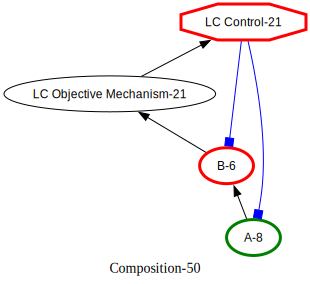

In [199]:
comp.show_graph(output_fmt='jupyter', show_controller=True)

In [200]:
trials = [1, 2, 3]


comp.run(inputs={mech_A: trials})
print(comp.results)

[[[0.67503753]
  [1.00279552]]

 [[0.70761873]
  [1.00572034]]

 [[0.72288085]
  [1.00878719]]]


To make clear what the LC Control Mechanism is doing, we can implement the same composition with a Vanilla Control Mechanism:

/Users/younesstrittmatter/Documents/GitHub/Princeton/PsyNeuLink/psyneulink/core/compositions/composition.py:7562: UserWarning: No new Projections were added to 'LC Control 2-31' that was included in the in 'pathway' arg for add_linear_processing_pathway method of 'Composition-51', since it has an ObjectiveMechanism that was specified in its constructor.
  warnings.warn(f"No new {Projection.__name__}s were added to '{item.name}' "


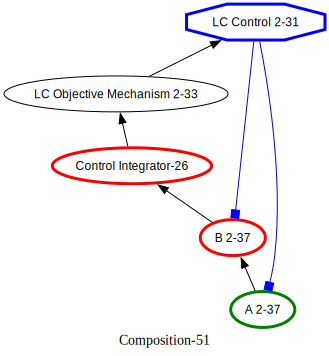

In [201]:
mech_A_2 = pnl.ProcessingMechanism(name='A 2', function=pnl.Logistic)
mech_B_2 = pnl.ProcessingMechanism(name='B 2', function=pnl.Logistic)

# The LC Control Mechanism uses the output of the FitzHughNagumoIntegrator:
# This function has 3 return values: The LC uses the second return value, scales it and adds the base level gain to it.
control_integrator = pnl.ProcessingMechanism(name='Control Integrator',
                                             function=pnl.FitzHughNagumoIntegrator,
                                             output_ports=[
                                                 {
                                                     pnl.NAME: 'Control Integrator Output',
                                                     pnl.VARIABLE: (pnl.OWNER_VALUE, 1),
                                                     pnl.FUNCTION: lambda x: BASE_LEVEL_GAIN + SCALING_FACTOR_GAIN * x,
                                                 }
                                             ])
# Now we can use a vanilla control mechanism to modulate the gain of A and B:
lc_control_2 = pnl.ControlMechanism(
    name='LC Control 2',
    control=[
        pnl.ControlSignal(modulates=(pnl.GAIN, mech_A_2)),  # modulates the gain of A
        pnl.ControlSignal(modulates=(pnl.GAIN, mech_B_2)),  # modulates the gain of B
    ],
    objective_mechanism=pnl.ObjectiveMechanism(
        name='LC Objective Mechanism 2',
        monitor=[control_integrator]  # Monitor the output of the control integrator
    ))

comp_2 = pnl.Composition()

# here we also define B and lc_control as output nodes
comp_2.add_node(mech_B_2, required_roles=pnl.NodeRole.OUTPUT)

comp_2.add_linear_processing_pathway([mech_A_2, mech_B_2, control_integrator, lc_control_2])

comp_2.show_graph(output_fmt='jupyter', show_controller=True)

In [202]:
comp_2.run(inputs={mech_A_2: [1, 2, 3]})


comp_2.results

array([[[0.67503753],
        [1.00279552]],

       [[0.70761873],
        [1.00572034]],

       [[0.72288085],
        [1.00878719]]])